In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = "Ga"
slab_pkl = open("data/GaN_0001_3x3_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)

system_settings = {
    "surface_name": "GaN(0001)",
    "cutoff": 5.0,
    "num_ads_atoms": 12,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 0.99,  # slowly anneal
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 50,
    "sweep_size": 104,
}

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "chem_pots": {"Ga": 5},  # eV. arbitrary value
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": "GaN(0001)",
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 0.   ,  0.   , 14.766]), array([12.865,  7.428, 14.12 ]), array([12.865,  5.571, 14.766]), array([11.257,  4.642, 14.12 ]), array([ 1.608,  2.785, 14.766])]...


In [5]:
pristine_slab.get_tags()

array([4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3,
       2, 1, 4, 3, 2, 1, 4, 3, 2, 1, 4, 3, 2, 1])

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [6]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

run directory: GaN(0001) is set from parameters
relaxation steps: 100 is set from parameters


Initialize surface system

In [7]:
# fix bulk atoms
num_bulk_atoms = len(pristine_slab)
bulk_indices = list(range(num_bulk_atoms))
print(f"bulk indices {bulk_indices}")
surf_indices = pristine_slab.get_surface_atoms()

fix_indices = list(set(bulk_indices) - set(surf_indices))
print(f"fix indices {fix_indices}")

# bulk atoms are 0 and surface atoms are 1
tags = np.ones(num_bulk_atoms)
tags[fix_indices] = 0
pristine_slab.set_tags(tags)
print(f"tags {tags}")

surface = SurfaceSystem(
    pristine_slab,
    ads_coords=ads_positions,
    calc=lammps_surf_calc,
    system_settings=system_settings,
)

surface.all_atoms.write("GaN_0001_3x3_all_virtual_ads.cif")

2024-06-20 11:45:55,192|INFO|initializing 104 virtual atoms
2024-06-20 11:45:55,200|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-20 11:45:55,201|INFO|number of pristine atoms is 36
2024-06-20 11:45:55,201|INFO|bulk indices are [ 2  3  6  7 10 11 14 15 18 19 22 23 26 27 30 31 34 35]
2024-06-20 11:45:55,202|INFO|surface indices are [ 0  1  4  5  8  9 12 13 16 17 20 21 24 25 28 29 32 33]
2024-06-20 11:45:55,202|INFO|Real atoms have constraints [FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])]


bulk indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
fix indices [2, 3, 34, 35, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31]
tags [1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]


2024-06-20 11:45:55,377|INFO|Relaxed atoms have constraints [FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])]


Total wall time: 0:00:00


Test calculate pristine surface

In [8]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

Total wall time: 0:00:00
Energy -144.059 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `GaN(0001)/` folder.

2024-06-20 11:45:55,475|INFO|there are 36 atoms in pristine slab
2024-06-20 11:45:55,477|INFO|Running with num_sweeps = 50, temp = 1.0, pot = [5], alpha = 0.99
2024-06-20 11:45:55,477|INFO|In pristine slab, there are a total of 104 sites


2024-06-20 11:45:55,484|INFO|randomly adsorbing sites


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:45:55,706|INFO|running for 104 iterations per run over a total of 50 runs
2024-06-20 11:45:55,706|INFO|starting with iteration 0
2024-06-20 11:45:55,707|INFO|In sweep 1 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total w

2024-06-20 11:45:58,052|INFO|At iter 104
2024-06-20 11:45:58,095|INFO|optim structure has Energy = -176.6664070200787
2024-06-20 11:45:58,101|INFO|In sweep 2 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:00,193|INFO|At iter 208
2024-06-20 11:46:00,246|INFO|optim structure has Energy = -178.79600067205456
2024-06-20 11:46:00,252|INFO|In sweep 3 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:02,399|INFO|At iter 312
2024-06-20 11:46:02,439|INFO|optim structure has Energy = -177.90851604981955
2024-06-20 11:46:02,451|INFO|In sweep 4 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:04,532|INFO|At iter 416
2024-06-20 11:46:04,568|INFO|optim structure has Energy = -177.47001454875533
2024-06-20 11:46:04,573|INFO|In sweep 5 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:06,784|INFO|At iter 520
2024-06-20 11:46:06,833|INFO|optim structure has Energy = -177.87134259428893
2024-06-20 11:46:06,838|INFO|In sweep 6 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:09,056|INFO|At iter 624
2024-06-20 11:46:09,090|INFO|optim structure has Energy = -174.35094717568666
2024-06-20 11:46:09,095|INFO|In sweep 7 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:11,292|INFO|At iter 728
2024-06-20 11:46:11,340|INFO|optim structure has Energy = -178.00288187107753
2024-06-20 11:46:11,345|INFO|In sweep 8 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:13,587|INFO|At iter 832
2024-06-20 11:46:13,629|INFO|optim structure has Energy = -174.05460987346768
2024-06-20 11:46:13,635|INFO|In sweep 9 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:15,860|INFO|At iter 936
2024-06-20 11:46:15,909|INFO|optim structure has Energy = -177.14455896534812
2024-06-20 11:46:15,915|INFO|In sweep 10 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:18,105|INFO|At iter 1040


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:18,158|INFO|optim structure has Energy = -177.99402814026118
2024-06-20 11:46:18,164|INFO|In sweep 11 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:20,663|INFO|At iter 1144
2024-06-20 11:46:20,705|INFO|optim structure has Energy = -176.6956394896472
2024-06-20 11:46:20,711|INFO|In sweep 12 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:23,048|INFO|At iter 1248
2024-06-20 11:46:23,112|INFO|optim structure has Energy = -176.6759480511044
2024-06-20 11:46:23,118|INFO|In sweep 13 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:25,496|INFO|At iter 1352


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:25,547|INFO|optim structure has Energy = -176.2598722650211
2024-06-20 11:46:25,556|INFO|In sweep 14 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:27,799|INFO|At iter 1456


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:27,839|INFO|optim structure has Energy = -178.56010674995184
2024-06-20 11:46:27,845|INFO|In sweep 15 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:30,170|INFO|At iter 1560
2024-06-20 11:46:30,213|INFO|optim structure has Energy = -174.8020876047876
2024-06-20 11:46:30,219|INFO|In sweep 16 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:32,354|INFO|At iter 1664
2024-06-20 11:46:32,395|INFO|optim structure has Energy = -178.3044103584383
2024-06-20 11:46:32,401|INFO|In sweep 17 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:34,474|INFO|At iter 1768
2024-06-20 11:46:34,521|INFO|optim structure has Energy = -178.40494739334108
2024-06-20 11:46:34,527|INFO|In sweep 18 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:36,604|INFO|At iter 1872
2024-06-20 11:46:36,639|INFO|optim structure has Energy = -176.66263359084516
2024-06-20 11:46:36,644|INFO|In sweep 19 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:38,830|INFO|At iter 1976


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:38,880|INFO|optim structure has Energy = -178.10873157803545
2024-06-20 11:46:38,887|INFO|In sweep 20 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:41,064|INFO|At iter 2080
2024-06-20 11:46:41,100|INFO|optim structure has Energy = -174.23798698307203
2024-06-20 11:46:41,110|INFO|In sweep 21 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:43,324|INFO|At iter 2184
2024-06-20 11:46:43,360|INFO|optim structure has Energy = -175.07802694016496
2024-06-20 11:46:43,368|INFO|In sweep 22 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:45,642|INFO|At iter 2288
2024-06-20 11:46:45,687|INFO|optim structure has Energy = -177.30117634325197
2024-06-20 11:46:45,694|INFO|In sweep 23 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:48,145|INFO|At iter 2392
2024-06-20 11:46:48,191|INFO|optim structure has Energy = -176.32364067823204
2024-06-20 11:46:48,197|INFO|In sweep 24 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:50,308|INFO|At iter 2496
2024-06-20 11:46:50,345|INFO|optim structure has Energy = -175.075524997563
2024-06-20 11:46:50,356|INFO|In sweep 25 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:52,515|INFO|At iter 2600


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:52,562|INFO|optim structure has Energy = -176.5763936248483
2024-06-20 11:46:52,568|INFO|In sweep 26 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:54,660|INFO|At iter 2704
2024-06-20 11:46:54,703|INFO|optim structure has Energy = -174.77568997559652
2024-06-20 11:46:54,709|INFO|In sweep 27 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:56,907|INFO|At iter 2808


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:56,969|INFO|optim structure has Energy = -179.1009307340719
2024-06-20 11:46:56,976|INFO|In sweep 28 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:46:59,131|INFO|At iter 2912
2024-06-20 11:46:59,172|INFO|optim structure has Energy = -176.08649178392753
2024-06-20 11:46:59,177|INFO|In sweep 29 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:01,352|INFO|At iter 3016
2024-06-20 11:47:01,388|INFO|optim structure has Energy = -176.14744622941072
2024-06-20 11:47:01,393|INFO|In sweep 30 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:03,508|INFO|At iter 3120
2024-06-20 11:47:03,546|INFO|optim structure has Energy = -173.70345361351102
2024-06-20 11:47:03,551|INFO|In sweep 31 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:05,670|INFO|At iter 3224
2024-06-20 11:47:05,706|INFO|optim structure has Energy = -176.71065882031658
2024-06-20 11:47:05,712|INFO|In sweep 32 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:07,869|INFO|At iter 3328
2024-06-20 11:47:07,920|INFO|optim structure has Energy = -179.25799387412488


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:07,927|INFO|In sweep 33 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:10,237|INFO|At iter 3432
2024-06-20 11:47:10,278|INFO|optim structure has Energy = -176.1847920627999
2024-06-20 11:47:10,284|INFO|In sweep 34 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:12,431|INFO|At iter 3536
2024-06-20 11:47:12,474|INFO|optim structure has Energy = -178.42133161056745
2024-06-20 11:47:12,480|INFO|In sweep 35 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:14,609|INFO|At iter 3640
2024-06-20 11:47:14,657|INFO|optim structure has Energy = -175.6123628423468
2024-06-20 11:47:14,664|INFO|In sweep 36 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:16,795|INFO|At iter 3744
2024-06-20 11:47:16,836|INFO|optim structure has Energy = -177.99375294108538
2024-06-20 11:47:16,841|INFO|In sweep 37 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:18,922|INFO|At iter 3848
2024-06-20 11:47:18,964|INFO|optim structure has Energy = -177.09909947040853
2024-06-20 11:47:18,971|INFO|In sweep 38 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:21,163|INFO|At iter 3952
2024-06-20 11:47:21,219|INFO|optim structure has Energy = -178.870318533475
2024-06-20 11:47:21,227|INFO|In sweep 39 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:23,450|INFO|At iter 4056


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:23,495|INFO|optim structure has Energy = -177.79658643642404
2024-06-20 11:47:23,504|INFO|In sweep 40 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:25,656|INFO|At iter 4160
2024-06-20 11:47:25,697|INFO|optim structure has Energy = -174.78265302799474
2024-06-20 11:47:25,703|INFO|In sweep 41 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:27,867|INFO|At iter 4264
2024-06-20 11:47:27,909|INFO|optim structure has Energy = -177.26169128407363
2024-06-20 11:47:27,920|INFO|In sweep 42 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:30,111|INFO|At iter 4368


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:30,154|INFO|optim structure has Energy = -178.3794180468546
2024-06-20 11:47:30,160|INFO|In sweep 43 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:32,327|INFO|At iter 4472
2024-06-20 11:47:32,370|INFO|optim structure has Energy = -175.8435915872883
2024-06-20 11:47:32,375|INFO|In sweep 44 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:34,679|INFO|At iter 4576


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:34,718|INFO|optim structure has Energy = -178.4999589770116
2024-06-20 11:47:34,723|INFO|In sweep 45 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:36,917|INFO|At iter 4680
2024-06-20 11:47:36,961|INFO|optim structure has Energy = -176.94160223549818
2024-06-20 11:47:36,971|INFO|In sweep 46 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:39,235|INFO|At iter 4784
2024-06-20 11:47:39,274|INFO|optim structure has Energy = -175.18684042181133
2024-06-20 11:47:39,280|INFO|In sweep 47 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:41,584|INFO|At iter 4888


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:41,625|INFO|optim structure has Energy = -176.6809352550329
2024-06-20 11:47:41,632|INFO|In sweep 48 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:43,748|INFO|At iter 4992
2024-06-20 11:47:43,790|INFO|optim structure has Energy = -177.54874444661164
2024-06-20 11:47:43,797|INFO|In sweep 49 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:46,054|INFO|At iter 5096
2024-06-20 11:47:46,098|INFO|optim structure has Energy = -174.600472443181
2024-06-20 11:47:46,110|INFO|In sweep 50 out of 50


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


2024-06-20 11:47:48,365|INFO|At iter 5200
2024-06-20 11:47:48,413|INFO|optim structure has Energy = -174.6650551995865


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 113.25531188957393 seconds


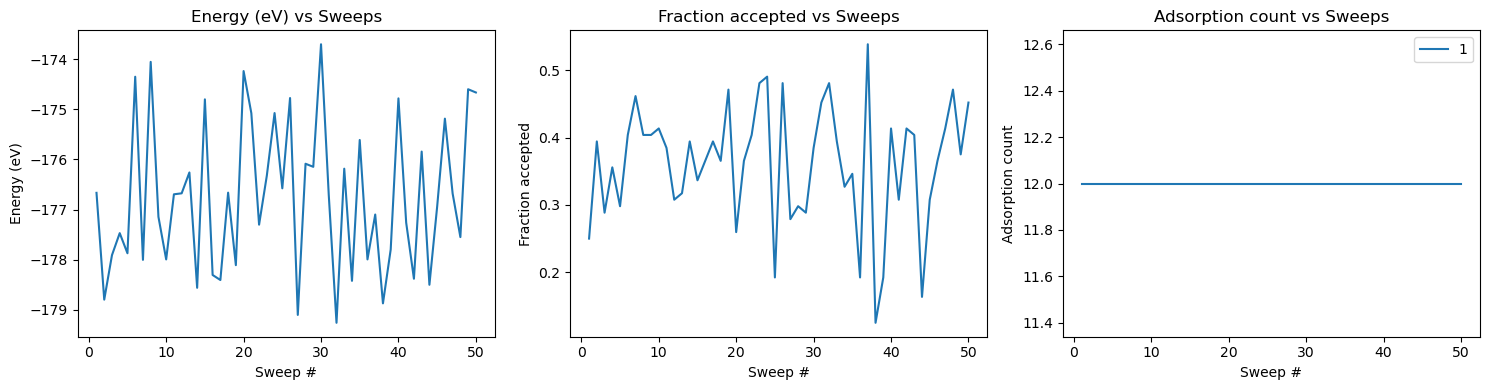

In [9]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=lammps_surf_calc,
    canonical=True,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    optimizer=calc_settings["optimizer"],
    num_ads_atoms=system_settings["num_ads_atoms"],
)

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")